# Training GCNAE

This notebook shows how to train the anomaly detection model.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import optuna

from models import GraphAE
from parameters import GraphAEParameters, TrainingParameters
from datautils import get_morning_data, get_gcnae_sequence
from training import save_model, load_model, train_gcnae, compute_anomaly_threshold_gcnae, test_model, threshold_anomalies, fill_result_df, test_gcnae
import torch.nn as nn
from tqdm import tqdm

import random
import os

/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [3]:
training_params = TrainingParameters(
    learning_rate=1e-4,
    batch_size=1,
    timesteps=10,
    n_epochs=3
)

In [4]:
training_data = get_gcnae_sequence(1, timesteps=training_params.timesteps) # train on day 1, free of crashes

In [5]:
hyperparams = GraphAEParameters(
    num_features=training_data[0].num_features,
    latent_dim=32,
    gcn_hidden_dim=64,
    dropout=0.2,
    num_gcn=2
)

In [6]:
ae = GraphAE(hyperparams)

In [7]:
ae(training_data[0]).shape

torch.Size([196, 3])

In [8]:
shapes = [data.x.shape for data in training_data]
for shape in shapes:
    if not shape == torch.Size([196, 3]):
        print("Error")

In [9]:
ae, losses = train_gcnae(gcnaeparams=hyperparams, trainingparams=training_params, training_data=training_data, mse_weights=mse_weights, verbose=True)

 33%|███▎      | 1/3 [00:06<00:12,  6.48s/it]

Epoch number 0 last 100 loss 0.015518658659420908


 67%|██████▋   | 2/3 [00:12<00:06,  6.45s/it]

Epoch number 1 last 100 loss 0.008771341851679609


100%|██████████| 3/3 [00:19<00:00,  6.50s/it]

Epoch number 2 last 100 loss 0.009685776609694585


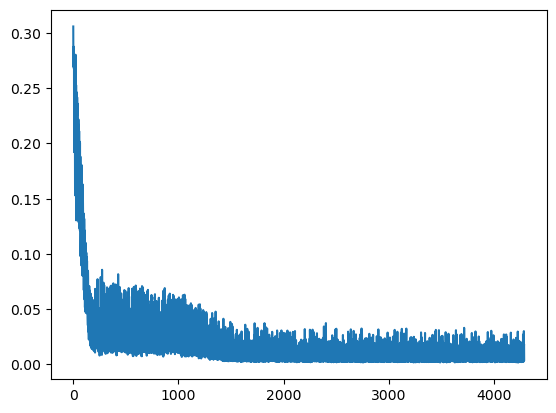

In [10]:
plt.plot(losses)

In [11]:
use_pretrained = False
if use_pretrained:
    study_name = 'gcn_ae_w4'  # Replace with your study name
    storage_subdirectory = 'studies'
    storage_url = f'sqlite:///{os.path.join(storage_subdirectory, study_name)}.db'
    study = optuna.load_study(study_name='gcn_ae_w4', storage=storage_url)

    # Get the best hyperparameters
    # best_params = study.best_params
    best_params = study.trials[56].params
    print(best_params)
    mse_weights = [1,4,1]

    training_data = get_morning_data(1, best_params['timesteps'])
    ae_params = STAEParameters(
        num_features=training_data[0][0].num_features,
        latent_dim=best_params['latent_dim'],
        gcn_hidden_dim=best_params['gcn_hidden_dim'],
        lstm_hidden_dim=best_params['lstm_hidden_dim'],
        lstm_num_layers=best_params['lstm_num_layers'],
        dropout=best_params['dropout'] # should not need this
    )

    ae = load_model(SpatioTemporalAutoencoder, ae_params, 'opt_57')

    test_data = get_morning_data(4, timesteps=best_params['timesteps'])

In [12]:
thresh = compute_anomaly_threshold_gcnae(training_data, ae, mse_weights, 'max')

100%|██████████| 1430/1430 [00:03<00:00, 458.62it/s]


In [13]:
use_pretrained = False
if not use_pretrained:
    test_data = get_gcnae_sequence(4, timesteps=training_params.timesteps)

In [14]:
test_errors, test_recons_speeds, test_true_speeds = test_gcnae(test_data, mse_weights, ae)

In [15]:
np.mean(test_errors)

0.013882254

In [16]:
anomalies = threshold_anomalies(thresh, test_errors)

In [17]:
df = fill_result_df(anomalies, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [18]:
df.to_csv('./saved_results/day4_results_test_rstae.csv')

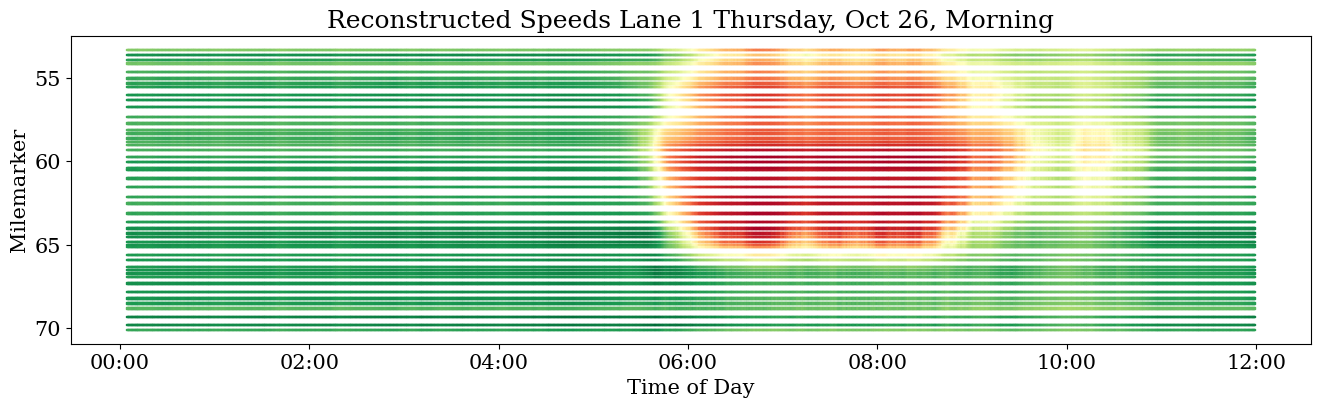

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./saved_results/day4_results_test_rstae.csv', index_col=0)
data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

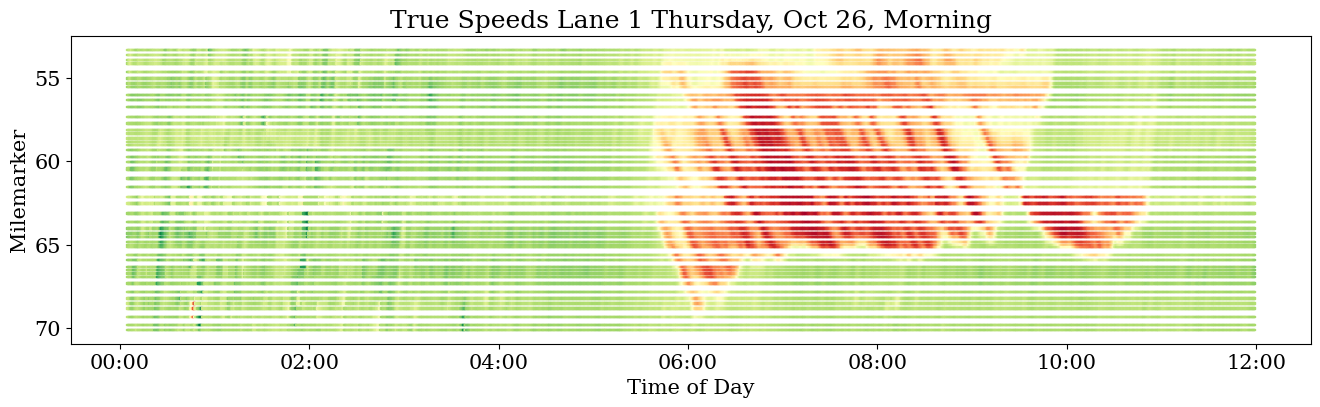

In [20]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 09:30:00')
end_time = pd.to_datetime('1970-01-01 09:50:00')
# plt.xlim(start_time, end_time)
# plt.ylim()

plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

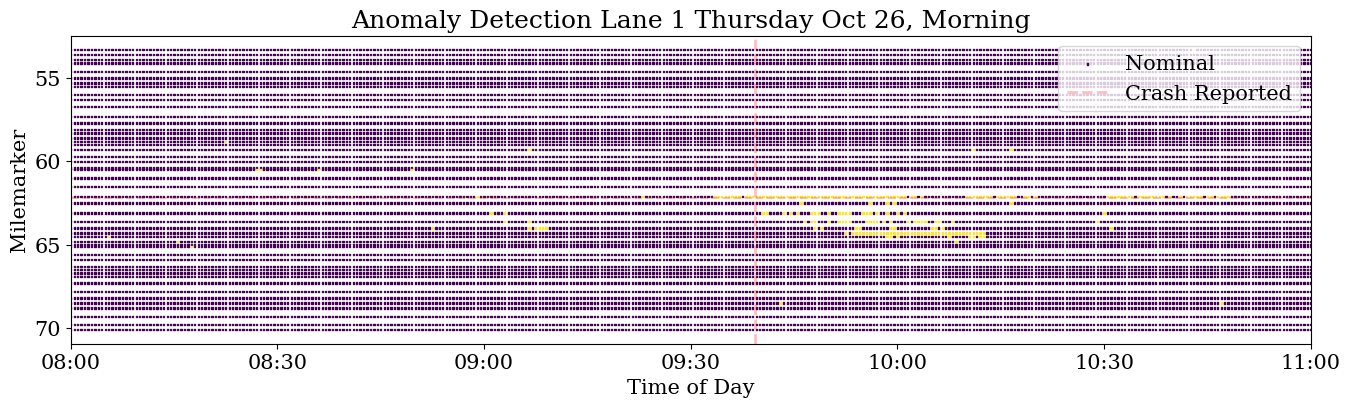

In [21]:
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 08:00:00')
end_time = pd.to_datetime('1970-01-01 11:00:00')
plt.xlim(start_time, end_time)

# Add vertical line at '1970-01-01 09:39:22'
vline_time = pd.to_datetime('1970-01-01 09:39:22')
plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# plt.ylim(60,65)
plt.legend(loc='upper right')
plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()